In [3]:

from google.cloud import storage
import pandas as pd
import pyarrow.parquet as pq
import io

# 한글 깨짐 방지 (옵션)
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 부호 깨짐 방지

In [ ]:
# # 폴더 안 파일 한꺼번에 불러오기

# from google.cloud import storage
# import pandas as pd
# import io

# client = storage.Client()
# bucket_name = 'sprint_project4'
# prefix = 'hackle/'  # 버킷 내 폴더 경로 (접두사)

# bucket = client.bucket(bucket_name)

# # prefix(폴더 경로)로 파일 리스트 조회
# blobs = bucket.list_blobs(prefix=prefix)

# dfs = []
# for blob in blobs:
#     if blob.name.endswith('.parquet'):  # parquet 파일만 처리
#         print(f'Downloading {blob.name}')
#         parquet_bytes = blob.download_as_bytes()
#         df = pd.read_parquet(io.BytesIO(parquet_bytes))
#         dfs.append(df)

# # 여러 DataFrame 병합 예시 (필요시)
# if dfs:
#     combined_df = pd.concat(dfs, ignore_index=True)
#     print(combined_df.head())
# else:
#     print("No parquet files found.")

### votes 테이블

In [4]:
client = storage.Client()

In [5]:
bucket_name = 'sprint_project4'
file_path = "sprint_project4/votes"

In [6]:
bucket = client.bucket(bucket_name)
blob = bucket.blob(file_path)

#### 1. accounts_attendance (출석 테이블)

In [5]:
blob = bucket.blob('votes/accounts_attendance.parquet')
parquet_bytes = blob.download_as_bytes()
attendance = pd.read_parquet(io.BytesIO(parquet_bytes))
attendance.head()

,id,attendance_date_list,user_id
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453


In [6]:
attendance.shape

(349637, 3)

In [7]:
attendance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349637 entries, 0 to 349636
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    349637 non-null  int64 
 1   attendance_date_list  349637 non-null  object
 2   user_id               349637 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.0+ MB


In [8]:
attendance['user_id'].nunique()

349637

In [9]:
# 출석률을 알아보자
attendance_df = attendance.copy()

import pandas as pd
import ast


# attendance_date_list 리스트 변환
attendance_df['attendance_date_list'] = attendance_df['attendance_date_list'].apply(ast.literal_eval)

# 출석 횟수 계산
attendance_df['attendance_count'] = attendance_df['attendance_date_list'].apply(len)

print(attendance_df[['user_id', 'attendance_count']])


        user_id  attendance_count
0       1446852                13
1       1359398                33
2       1501542                 9
3       1507767                30
4       1287453                31
...         ...               ...
349632   897005                 0
349633  1407059                 1
349634  1583727                 1
349635  1392372                 1
349636  1583730                 1

[349637 rows x 2 columns]


In [10]:
attendance_df['attendance_count'].value_counts()

attendance_count
1      78867
2      46394
3      32060
4      24314
0      20945
       ...  
194        1
143        1
249        1
242        1
190        1
Name: count, Length: 209, dtype: int64

In [11]:
attendance_df.describe()

,id,user_id,attendance_count
count,349637.000000,3.496370e+05,349637.000000
mean,180550.143772,1.247187e+06,6.356098
std,104168.322237,2.127986e+05,9.158459
min,1.000000,8.321510e+05,0.000000
25%,90432.000000,1.065813e+06,1.000000
50%,180749.000000,1.261234e+06,3.000000
75%,270674.000000,1.437486e+06,8.000000
max,360505.000000,1.583730e+06,310.000000


In [12]:
# 출석률 75% 이상인 사용자들
max_attendacne = attendance_df['attendance_count'].max()
max_attendacne

310

In [13]:
attendance_75df = attendance_df[attendance_df['attendance_count'] < 0.75 * max_attendacne]

print(attendance_75df[['user_id', 'attendance_count']])

        user_id  attendance_count
0       1446852                13
1       1359398                33
2       1501542                 9
3       1507767                30
4       1287453                31
...         ...               ...
349632   897005                 0
349633  1407059                 1
349634  1583727                 1
349635  1392372                 1
349636  1583730                 1

[349620 rows x 2 columns]


In [14]:
attendance_75df['user_id'].nunique()

349620

In [15]:
attendance_75df.describe()

,id,user_id,attendance_count
count,349620.000000,3.496200e+05,349620.000000
mean,180554.770991,1.247181e+06,6.343487
std,104166.650294,2.127989e+05,8.977426
min,1.000000,8.321510e+05,0.000000
25%,90439.750000,1.065794e+06,1.000000
50%,180754.500000,1.261218e+06,3.000000
75%,270677.250000,1.437476e+06,8.000000
max,360505.000000,1.583730e+06,230.000000


In [16]:
attendance_df[attendance_df['attendance_count'] >= 190].count()

id                      37
attendance_date_list    37
user_id                 37
attendance_count        37
dtype: int64

#### 2. accounts_blockrecord (차단 기록 테이블)

In [17]:
blob = bucket.blob('votes/accounts_blockrecord.parquet')
parquet_bytes = blob.download_as_bytes()
blockrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
blockrecord.head()

,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,2,친구 사이가 어색해짐,2023-05-05 01:17:08,867190,867564
2,3,나랑 관련 없는 질문을 자꾸 보냄,2023-05-05 01:50:55,875110,875261
3,6,그냥...,2023-05-05 05:21:52,883696,883511
4,7,그냥...,2023-05-05 06:40:34,871349,870177


In [18]:
blockrecord.shape

(19482, 5)

In [19]:
blockrecord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19482 entries, 0 to 19481
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19482 non-null  int64         
 1   reason         19482 non-null  object        
 2   created_at     19482 non-null  datetime64[ns]
 3   block_user_id  19482 non-null  int64         
 4   user_id        19482 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 761.1+ KB


In [20]:
blockrecord['user_id'].nunique()

12552

In [21]:
blockrecord['block_user_id'].nunique()

16240

In [22]:
# reason, block_user_id, user_id가 모두 중복이면?? 중복처리???
blockrecord_duplicated = blockrecord[blockrecord.duplicated(subset=['reason', 'block_user_id', 'user_id'], keep=False)]
blockrecord_duplicated

,id,reason,created_at,block_user_id,user_id
8,12,기타,2023-05-05 13:04:31,885794,879662
9,13,기타,2023-05-05 13:04:42,885794,879662
11,15,기타,2023-05-05 13:04:56,885794,879662
12,16,기타,2023-05-05 13:05:01,885794,879662
13,17,친구 사이가 어색해짐,2023-05-05 13:17:19,886605,881070
...,...,...,...,...,...
19227,24885,모르는 사람임,2023-08-15 18:38:38,992181,1072478
19228,24886,모르는 사람임,2023-08-15 18:38:41,992181,1072478
19240,24899,친구 사이가 어색해짐,2023-08-18 12:12:28,1500131,1365572
19295,25105,모르는 사람임,2023-09-11 14:09:18,1019326,976341


In [23]:
# 유니크 유저 수
blockrecord_duplicated['user_id'].nunique()

401

In [24]:
# 차단당한 유저들
blockrecord['block_user_id'].nunique()

16240

In [25]:
# 유저들 차단당한 이유
blockrecord['reason'].value_counts()

reason
모르는 사람임               9640
친구 사이가 어색해짐           5805
사칭 계정                 2022
나랑 관련 없는 질문을 자꾸 보냄    1083
너무 많은 양의 질문을 보냄        919
기타                       7
그냥...                    6
Name: count, dtype: int64

##### 2-1. 여러 명을 차단한 유저

In [26]:
# 여러 명을 차단한 유저 추출
duplicated_blockrecord = blockrecord[blockrecord.duplicated('user_id', keep = False)]
duplicated_blockrecord

,id,reason,created_at,block_user_id,user_id
7,11,친구 사이가 어색해짐,2023-05-05 12:19:37,885588,875490
8,12,기타,2023-05-05 13:04:31,885794,879662
9,13,기타,2023-05-05 13:04:42,885794,879662
10,14,그냥...,2023-05-05 13:04:52,885794,879662
11,15,기타,2023-05-05 13:04:56,885794,879662
...,...,...,...,...,...
19475,25353,사칭 계정,2024-04-05 08:14:55,871694,879416
19476,25354,사칭 계정,2024-04-05 08:15:00,876777,879416
19477,25355,사칭 계정,2024-04-05 08:15:03,875351,879416
19478,25356,친구 사이가 어색해짐,2024-04-25 09:28:19,1444256,1292346


In [27]:
# reason별 선택 횟수
display(duplicated_blockrecord['reason'].value_counts())

reason
모르는 사람임               5023
친구 사이가 어색해짐           2943
사칭 계정                  849
나랑 관련 없는 질문을 자꾸 보냄     452
너무 많은 양의 질문을 보냄        390
기타                       5
그냥...                    1
Name: count, dtype: int64

##### 2-2. 여러 번 차단 당한 유저

In [28]:
# 여러 번 차단 당한 이용자들
duplicated_blockrecord_blockuser = blockrecord[blockrecord.duplicated('block_user_id', keep = False)]
duplicated_blockrecord_blockuser

,id,reason,created_at,block_user_id,user_id
8,12,기타,2023-05-05 13:04:31,885794,879662
9,13,기타,2023-05-05 13:04:42,885794,879662
10,14,그냥...,2023-05-05 13:04:52,885794,879662
11,15,기타,2023-05-05 13:04:56,885794,879662
12,16,기타,2023-05-05 13:05:01,885794,879662
...,...,...,...,...,...
19444,25309,사칭 계정,2024-03-28 11:42:09,880905,879416
19461,25337,사칭 계정,2024-03-29 14:56:19,876943,879416
19463,25340,사칭 계정,2024-03-31 04:59:36,860503,879416
19467,25345,사칭 계정,2024-03-31 04:59:54,867198,879416


In [29]:
duplicated_blockrecord_blockuser['block_user_id'].nunique()

1684

In [30]:
# 유저별 차단 당한 횟수(내림차순)
block_counts = duplicated_blockrecord_blockuser['block_user_id'].value_counts().reset_index()
block_counts.columns = ['block_user_id', 'block_count']

block_counts

,block_user_id,block_count
0,898020,76
1,897681,25
2,1380465,25
3,877266,25
4,1395312,24
...,...,...
1679,1143508,2
1680,1177947,2
1681,1042942,2
1682,842565,2


In [31]:
duplicated_blockrecord_blockuser['reason'].value_counts()

reason
모르는 사람임               2650
친구 사이가 어색해짐            972
사칭 계정                  595
나랑 관련 없는 질문을 자꾸 보냄     381
너무 많은 양의 질문을 보냄        321
기타                       5
그냥...                    2
Name: count, dtype: int64

In [32]:
duplicated_blockrecord_blockuser[duplicated_blockrecord_blockuser['block_user_id'] == 898020]

,id,reason,created_at,block_user_id,user_id
141,199,모르는 사람임,2023-05-06 12:31:32,898020,898071
165,230,친구 사이가 어색해짐,2023-05-06 13:18:40,898020,897693
192,274,모르는 사람임,2023-05-06 14:43:10,898020,897693
244,341,모르는 사람임,2023-05-06 15:47:17,898020,901327
248,346,모르는 사람임,2023-05-06 15:55:24,898020,898071
...,...,...,...,...,...
2418,3250,모르는 사람임,2023-05-10 09:14:20,898020,898283
2684,3609,너무 많은 양의 질문을 보냄,2023-05-10 14:23:20,898020,897704
3142,4233,모르는 사람임,2023-05-11 13:08:55,898020,1086219
3267,4399,나랑 관련 없는 질문을 자꾸 보냄,2023-05-11 14:48:35,898020,897916


In [33]:
pip install koreanize_matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
import koreanize_matplotlib

In [15]:
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

/tmp/ipykernel_433267/3323786163.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=reason_counts, x='reason', y='count', palette='Blues_d')


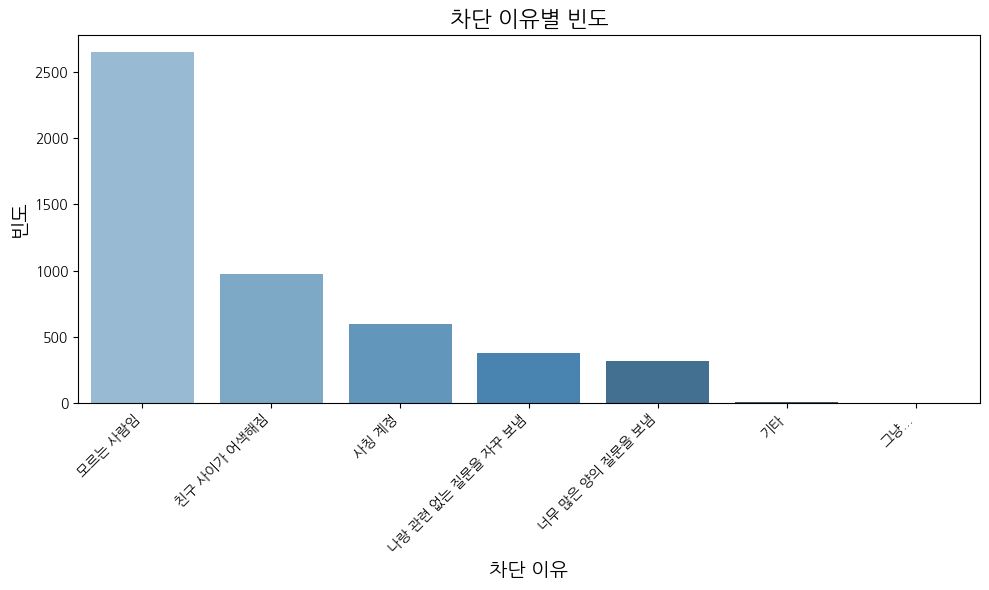

In [36]:

# 시각화를 위해 데이터 준비
reason_counts = duplicated_blockrecord_blockuser['reason'].value_counts().reset_index()
reason_counts.columns = ['reason', 'count']

# 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(data=reason_counts, x='reason', y='count', palette='Blues_d')

# 제목 및 축 이름 설정
plt.title('차단 이유별 빈도', fontsize=16)
plt.xlabel('차단 이유', fontsize=14)
plt.ylabel('빈도', fontsize=14)

# x축 레이블 각도 조정
plt.xticks(rotation=45, ha='right')

# 그래프 보기 좋게 조정
plt.tight_layout()

# 그래프 출력
plt.show()

#### 3. accounts_failpaymenthistory (상품 구매 실패 기록 테이블)

In [37]:
blob = bucket.blob('votes/accounts_failpaymenthistory.parquet')
parquet_bytes = blob.download_as_bytes()
failpaymenthistory = pd.read_parquet(io.BytesIO(parquet_bytes))
failpaymenthistory.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.200,A,2023-05-14 05:49:22,1055891
1,7,heart.777,A,2023-05-14 08:17:21,1152151
2,8,heart.777,A,2023-05-14 10:11:46,986200
3,9,heart.1000,A,2023-05-14 11:53:09,1028261
4,10,heart.777,A,2023-05-14 12:30:47,1235730


In [38]:
failpaymenthistory.shape

(163, 5)

In [39]:
failpaymenthistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          163 non-null    int64         
 1   productId   56 non-null     object        
 2   phone_type  163 non-null    object        
 3   created_at  163 non-null    datetime64[ns]
 4   user_id     163 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 6.5+ KB


In [40]:
failpaymenthistory.isnull().sum()

id              0
productId     107
phone_type      0
created_at      0
user_id         0
dtype: int64

In [41]:
failpaymenthistory[failpaymenthistory['productId'].isnull()]

,id,productId,phone_type,created_at,user_id
12,20,None,I,2023-05-15 16:26:51,1153256
13,21,None,I,2023-05-16 03:16:37,1230712
14,22,None,I,2023-05-16 06:40:04,1277817
15,23,None,I,2023-05-16 07:40:32,1254768
18,26,None,I,2023-05-16 11:31:51,1189806
...,...,...,...,...,...
155,167,None,I,2023-07-04 13:42:28,1575434
156,168,None,I,2023-07-12 12:14:11,925534
159,171,None,I,2023-08-12 11:26:59,1556867
161,173,None,I,2023-09-17 09:12:53,927108


In [42]:
failpaymenthistory['phone_type'].value_counts()

phone_type
I    107
A     56
Name: count, dtype: int64

In [43]:
failpaymenthistory['user_id'].nunique()

160

In [44]:
failpaymenthistory[failpaymenthistory.duplicated('user_id', keep = False)]

,id,productId,phone_type,created_at,user_id
52,60,None,I,2023-05-19 13:38:05,1322662
53,61,None,I,2023-05-19 13:38:32,1322662
136,146,None,I,2023-05-31 12:37:45,1211047
137,147,None,I,2023-05-31 12:38:35,1211047
161,173,None,I,2023-09-17 09:12:53,927108
162,174,None,I,2023-09-17 09:12:53,927108


#### 4. accounts_friendrequest (친구 요청 테이블)

- 악성유저란?
    - 친구 요청 횟수가 엄청 많은데 거절이 대부분 일때(모두 거절 당하면 오히려 좋음)
    - status가 계속 R -> R -> R 일 때
    

In [45]:
blob = bucket.blob('votes/accounts_friendrequest.parquet')
parquet_bytes = blob.download_as_bytes()
friendrequest = pd.read_parquet(io.BytesIO(parquet_bytes))
friendrequest.head()

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521


In [46]:
friendrequest.shape

(17147175, 6)

In [47]:
friendrequest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17147175 entries, 0 to 17147174
Data columns (total 6 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   status           object        
 2   created_at       datetime64[ns]
 3   updated_at       datetime64[ns]
 4   receive_user_id  int64         
 5   send_user_id     int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 784.9+ MB


In [48]:
friendrequest.isnull().sum()

id                 0
status             0
created_at         0
updated_at         0
receive_user_id    0
send_user_id       0
dtype: int64

In [49]:
# 친구 요청의 경우 한 유저가 여러 명의 유저에게 요청을 보낼 수 있음
# but send와 receive, status가 모드 같은 경우는 created_at과 updated_at의 상태를 살펴봐야함
# receive_user_id와 send_user_id가 같아 중복같지만 creqated_at과 updated_at이 중복이 아닐 경우 
# 첫 번째 친구 요청에서 거절 당한 후 재친구 요청일 수 있음
# 중복 요청이 있는데 모두 status가 R인 경우 악성 유저 아닌가....
# R -> A / P -> A => 이런 경우 존재하면 마지막 A인 경우만 남겨도?

friendrequest['status'].value_counts()

status
A    12878407
P     3938608
R      330160
Name: count, dtype: int64

In [ ]:
# send, receive, status 모두 같은 그룹별 중복 확인 
# created_at과 update_at에서 초의 차이만 있고 다른 부분들은 중복인 경우도 존재함함
friendrequest_duplicates = friendrequest[
    friendrequest.duplicated(subset=['status', 'receive_user_id', 'send_user_id'], keep=False)
].sort_values(by=['receive_user_id', 'send_user_id', 'status'])

In [ ]:
friendrequest_duplicates

,id,status,created_at,updated_at,receive_user_id,send_user_id
61330,81812,R,2023-04-24 09:27:25,2023-04-24 14:22:00,833376,844668
70722,94429,R,2023-04-25 05:02:46,2023-04-30 14:46:32,833376,844668
14187782,16328211,R,2023-05-25 01:37:36,2023-05-26 08:13:43,833673,1039406
15318771,17634582,R,2023-05-28 00:34:21,2023-05-29 14:58:41,833673,1039406
267741,345642,R,2023-04-30 15:05:54,2023-05-04 09:27:45,833714,852252
...,...,...,...,...,...,...
17140279,19685779,A,2024-03-11 14:34:21,2024-03-14 06:40:00,1583250,1583252
17141511,19687036,P,2024-03-19 14:56:09,2024-03-19 14:56:09,1583317,1583280
17141513,19687038,P,2024-03-19 14:56:11,2024-03-19 14:56:11,1583317,1583280
17142221,19687811,A,2024-03-23 08:51:38,2024-03-28 04:27:37,1583414,1568016


In [ ]:
# 친구 요청 여러 번 거절 당한 유저들 R-> R
friendrequest_reject = friendrequest_duplicates[friendrequest_duplicates['status'] == 'R']
friendrequest_reject

,id,status,created_at,updated_at,receive_user_id,send_user_id
61330,81812,R,2023-04-24 09:27:25,2023-04-24 14:22:00,833376,844668
70722,94429,R,2023-04-25 05:02:46,2023-04-30 14:46:32,833376,844668
14187782,16328211,R,2023-05-25 01:37:36,2023-05-26 08:13:43,833673,1039406
15318771,17634582,R,2023-05-28 00:34:21,2023-05-29 14:58:41,833673,1039406
267741,345642,R,2023-04-30 15:05:54,2023-05-04 09:27:45,833714,852252
...,...,...,...,...,...,...
17094358,19638308,R,2023-09-26 13:26:52,2023-09-26 14:12:14,1580700,1580679
17095216,19639231,R,2023-09-27 11:14:55,2023-09-28 00:41:42,1580700,1580679
17096373,19640434,R,2023-09-28 11:54:30,2023-09-30 10:34:05,1580700,1580679
17094161,19638105,R,2023-09-26 12:22:43,2023-09-26 14:12:22,1580700,1580758


In [53]:
# 친구 요청 거절 당한 유저들 중 여러번 거절 당한 유저들 -> 유저들 차단 당한 기록이 있나 확인 필요(왜 거절 당했을까?)
friendrequest_reject['send_user_id'].nunique()

26501

In [ ]:
# status가 P 또는 A인 경우

In [ ]:
# 중복 친구 요청 : 처음에는 R -> A / P -> A =>이런 경우 존재하면 마지막 A인 경우만 남겨도?


#### 5. accounts_group (학급 테이블)

In [91]:
blob = bucket.blob('votes/accounts_group.parquet')
parquet_bytes = blob.download_as_bytes()
group = pd.read_parquet(io.BytesIO(parquet_bytes))
group.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


In [92]:
group.shape

(84515, 4)

In [93]:
group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84515 entries, 0 to 84514
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         84515 non-null  int64
 1   grade      84515 non-null  int64
 2   class_num  84515 non-null  int64
 3   school_id  84515 non-null  int64
dtypes: int64(4)
memory usage: 2.6 MB


In [99]:
group.describe()

,id,grade,class_num,school_id
count,84515.000000,84515.000000,84515.000000,84515.000000
mean,42279.376087,2.113992,5.318606,3079.496468
std,24400.962630,0.754896,4.089901,1675.036093
min,1.000000,1.000000,0.000000,1.000000
25%,21147.500000,2.000000,2.000000,1752.000000
50%,42279.000000,2.000000,4.000000,3023.000000
75%,63411.500000,3.000000,7.000000,4620.000000
max,84546.000000,20.000000,41.000000,5965.000000


In [94]:
group['school_id'].value_counts()

school_id
3283    49
1773    44
1492    44
2212    43
271     43
        ..
3584     1
1324     1
2953     1
4070     1
1135     1
Name: count, Length: 5604, dtype: int64

In [95]:
group['school_id'].nunique()

5604

In [96]:
# 학년 4와 1은 이상치처리해서 제거하기
group['grade'].value_counts()

grade
2     35581
3     29273
1     19659
4         1
20        1
Name: count, dtype: int64

In [ ]:
# 학년별 반 학생 수
# 학교 
group_counts = group.groupby(['grade','class_num']).size().reset_index(name = 'group_counts')
group_counts

,grade,class_num,group_counts
0,1,1,2500
1,1,2,2402
2,1,3,2310
3,1,4,2138
4,1,5,2006
...,...,...,...
59,3,18,44
60,3,19,35
61,3,20,612
62,4,10,1


In [100]:
group['class_num'].value_counts()

class_num
1     12125
2     11077
3     10276
4      9506
5      8578
6      7555
7      6390
8      5294
9      3799
10     3067
20     2454
11     1600
12      998
13      506
14      311
18      217
15      216
17      214
19      177
16      152
0         2
41        1
Name: count, dtype: int64

#### 6. accounts_nearbyschool (가까운 학교를 기록해두기 위한 관계형 테이블)

In [82]:
blob = bucket.blob('votes/accounts_nearbyschool.parquet')
parquet_bytes = blob.download_as_bytes()
nearbyschool = pd.read_parquet(io.BytesIO(parquet_bytes))
nearbyschool.head()

,id,distance,nearby_school_id,school_id
0,119021,0.004564,6,7
1,119022,0.010787,13,7
2,119023,0.012928,20,7
3,119024,0.013590,4,7
4,119025,0.014122,24,7


In [87]:
nearbyschool.shape

(59500, 4)

In [88]:
nearbyschool.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59500 entries, 0 to 59499
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                59500 non-null  int64  
 1   distance          59500 non-null  float64
 2   nearby_school_id  59500 non-null  int64  
 3   school_id         59500 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 1.8 MB


In [85]:
nearbyschool['school_id'].nunique()

5950

#### 7. accounts_paymenthistory (구매 기록 테이블)

In [54]:
blob = bucket.blob('votes/accounts_paymenthistory.parquet')
parquet_bytes = blob.download_as_bytes()
paymetnhistory = pd.read_parquet(io.BytesIO(parquet_bytes))
paymetnhistory.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081


In [55]:
paymetnhistory.shape

(95140, 5)

In [56]:
paymetnhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95140 entries, 0 to 95139
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          95140 non-null  int64         
 1   productId   95140 non-null  object        
 2   phone_type  95140 non-null  object        
 3   created_at  95140 non-null  datetime64[ns]
 4   user_id     95140 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 3.6+ MB


In [57]:
paymetnhistory['productId'].value_counts()

productId
heart.777     57873
heart.1000    19309
heart.200     15822
heart.4000     2136
Name: count, dtype: int64

In [58]:
paymetnhistory['user_id'].nunique()

59192

In [60]:
# 유저별 구매 횟수
user_payment_counts = paymetnhistory.groupby('user_id').size().reset_index(name = 'purchase_count')\
.sort_values(by = 'purchase_count', ascending=False)
user_payment_counts

,user_id,purchase_count
55604,1527451,60
27744,1246471,51
17651,1141603,35
23067,1204373,34
17740,1142775,30
...,...,...
22263,1196164,1
22264,1196170,1
22265,1196185,1
22266,1196197,1


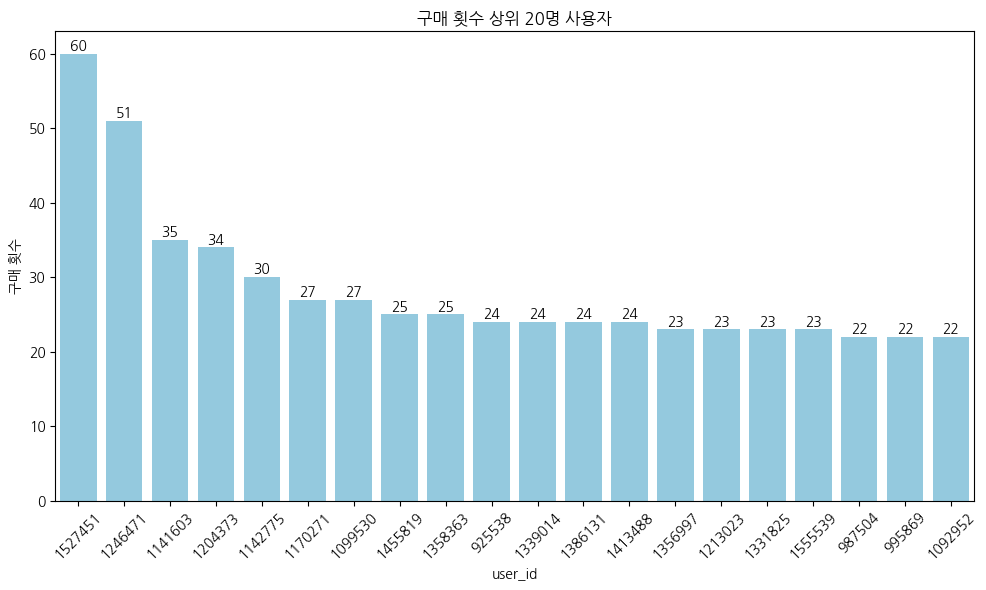

In [ ]:
# 구매 횟수 상위 20명
top_20_purchase = user_payment_counts.head(20)

# 시각화
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x=top_20_purchase['user_id'].astype(str),
    y=top_20_purchase['purchase_count'],
    color='skyblue'
)

# 텍스트로 숫자 표시
for i, row in top_20_purchase.iterrows():
    barplot.text(
        x=top_20_purchase.index.get_loc(i),        # 막대 위치
        y=row['purchase_count'] + 0.1,              # 막대 위에 조금 띄워서
        s=row['purchase_count'],                    # 표시할 숫자
        ha='center', va='bottom', fontsize=10       # 정렬과 글꼴 설정
    )

# 라벨 및 스타일
plt.xticks(rotation=45)
plt.xlabel('user_id')
plt.ylabel('구매 횟수')
plt.title('구매 횟수 상위 20명 사용자')
plt.tight_layout()
plt.show()


In [66]:
paymetnhistory[paymetnhistory['user_id'] == 1527451]

,id,productId,phone_type,created_at,user_id
73861,76309,heart.777,A,2023-05-28 08:49:02,1527451
73895,76344,heart.1000,A,2023-05-28 09:00:40,1527451
73903,76352,heart.200,A,2023-05-28 09:02:14,1527451
74060,76510,heart.200,A,2023-05-28 09:57:49,1527451
74827,77299,heart.200,A,2023-05-28 13:30:09,1527451
76064,78577,heart.200,A,2023-05-28 21:26:21,1527451
76065,78578,heart.200,A,2023-05-28 21:30:37,1527451
76066,78579,heart.200,A,2023-05-28 21:30:54,1527451
76067,78580,heart.200,A,2023-05-28 21:31:57,1527451
76068,78581,heart.200,A,2023-05-28 21:32:15,1527451


In [81]:
# 날짜별 구매 기록
paymetnhistory_df = paymetnhistory.copy()

paymetnhistory_df['date'] = paymetnhistory_df['created_at'].dt.date

daily_user_purchase = paymetnhistory_df.groupby(['date']) \
.size().reset_index(name = 'purchase_count')
daily_user_purchase

,date,purchase_count
0,2023-05-13,421
1,2023-05-14,12802
2,2023-05-15,6900
3,2023-05-16,7163
4,2023-05-17,5329
...,...,...
327,2024-05-02,4
328,2024-05-04,3
329,2024-05-05,5
330,2024-05-06,8


In [83]:
# 월별 구매 기록
daily_user_purchase['date'] = pd.to_datetime(daily_user_purchase['date'])

# 2. 월 단위 컬럼 추가 (형식: YYYY-MM)
daily_user_purchase['year_month'] = daily_user_purchase['date'].dt.to_period('M').astype(str)

# 3. 월별 구매 횟수 합산
monthly_purchase = daily_user_purchase.groupby('year_month')['purchase_count'].sum().reset_index()

# 결과 출력
print(monthly_purchase)

   year_month  purchase_count
0     2023-05           82188
1     2023-06            7709
2     2023-07            2227
3     2023-08            1418
4     2023-09             520
5     2023-10             228
6     2023-11             202
7     2023-12             204
8     2024-01             167
9     2024-02              77
10    2024-03              70
11    2024-04             107
12    2024-05              23


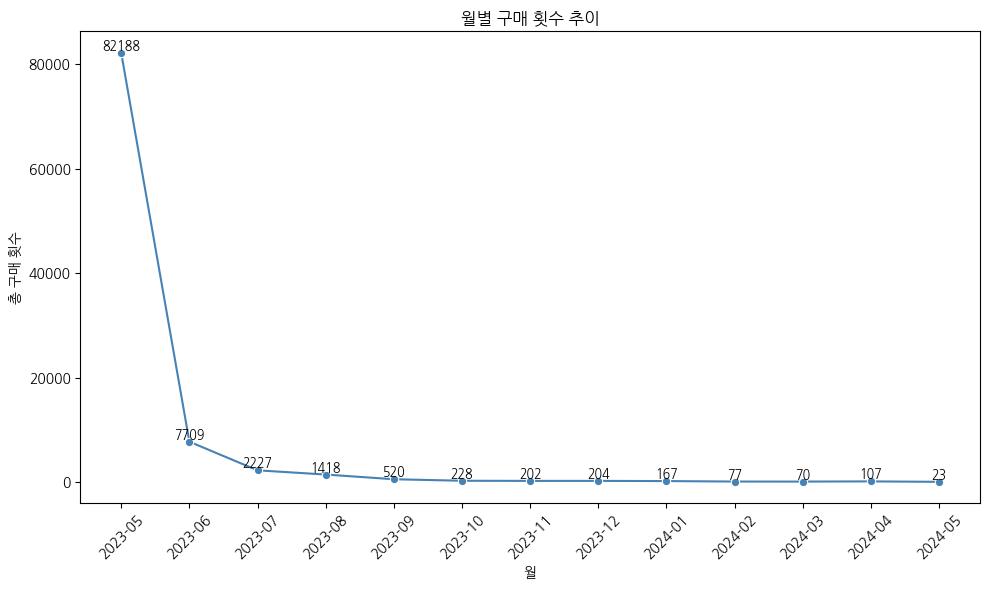

In [84]:
# 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_purchase, x='year_month', y='purchase_count', marker='o', color='steelblue')

# 수치 표시
for i, row in monthly_purchase.iterrows():
    plt.text(
        x=i,
        y=row['purchase_count'] + 0.5,
        s=row['purchase_count'],
        ha='center',
        va='bottom',
        fontsize=9
    )

# 스타일 설정
plt.xticks(rotation=45)
plt.xlabel('월')
plt.ylabel('총 구매 횟수')
plt.title('월별 구매 횟수 추이')
plt.tight_layout()
plt.show()

#### 8. accounts_user_contacts (유저 컨택 테이블)
- contacts_count : 이 전화번화를 가지고 있는 유저 수
- invite_user_id_list : 이 전화번호를 초대했전 유저 id 리스트
- but 해당 테이블은 phone_number 컬럼 드랍됨

In [85]:
blob = bucket.blob('votes/accounts_user_contacts.parquet')
parquet_bytes = blob.download_as_bytes()
user_contacts = pd.read_parquet(io.BytesIO(parquet_bytes))
user_contacts.head()

,id,contacts_count,invite_user_id_list,user_id
0,259,30,[],1167696
1,1756,79,[],863169
2,13742,21,[854615],857205
3,13754,29,[],851431
4,13756,28,[849318],855476


In [86]:
user_contacts.shape

(5063, 4)

In [87]:
user_contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5063 entries, 0 to 5062
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   5063 non-null   int64 
 1   contacts_count       5063 non-null   int64 
 2   invite_user_id_list  5063 non-null   object
 3   user_id              5063 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 158.3+ KB


In [102]:
# [] 이 경우 
user_contacts['invite_user_id_list'].value_counts().sort_values(ascending=False)

invite_user_id_list
[]                                                               3905
[1154585]                                                          15
[1233225]                                                          12
[1041381]                                                           9
[936990]                                                            7
                                                                 ... 
[1191711]                                                           1
[931759, 1047310, 984540, 1082102, 1099436, 1043473, 1113567]       1
[1135560]                                                           1
[1064681]                                                           1
[1461877]                                                           1
Name: count, Length: 928, dtype: int64

In [101]:
user_contacts[user_contacts['invite_user_id_list']=='[1154585]']

,id,contacts_count,invite_user_id_list,user_id
956,579912,25,[1154585],1266873
1031,607582,48,[1154585],1155224
1355,814683,23,[1154585],1155129
1357,814698,24,[1154585],1157292
2091,1296756,18,[1154585],1155289
2856,2005730,29,[1154585],1155319
2920,2128687,36,[1154585],1201068
3557,3380829,41,[1154585],1156031
3692,3706454,24,[1154585],1274398
3697,3728967,23,[1154585],1155315


In [ ]:
# 많은 유저들(invite_user_id_list)에게 초대 받은 이용자 수수
user_contacts_df = user_contacts.copy()

import ast
# 문자열을 리스트로 변환
user_contacts_df['invite_user_id_list'] = user_contacts_df['invite_user_id_list'].apply(ast.literal_eval)

# 각 리스트의 길이 계산
user_contacts_df['invite_user_count'] = user_contacts_df['invite_user_id_list'].apply(len)

# 초대한 유저 수별로 몇 명의 유저가 있는지 집계 → 데이터프레임화
invite_user_count_df = user_contacts_df['invite_user_count'] \
    .value_counts(ascending=False) \
    .reset_index()

# 컬럼 이름 지정
invite_user_count_df.columns = ['invite_user_count', 'num_users']

# 결과 확인
invite_user_count_df

,invite_user_count,num_users
0,0,3905
1,1,830
2,2,203
3,3,81
4,4,27
5,5,10
6,6,4
7,10,1
8,9,1
9,7,1


In [116]:
# 유저별 초대해준 유저 수

# 필요한 컬럼만 정리
received_invite_df = user_contacts_df[['user_id', 'invite_user_count']].copy()

# 결과 확인
received_invite_df.sort_values(by = 'invite_user_count', ascending= False)

,user_id,invite_user_count
1009,1207606,10
2141,932308,9
3340,1122686,7
1359,881627,6
3012,1008546,6
...,...,...
1963,1075165,0
1964,1217505,0
1965,916061,0
1966,872877,0


#### 9. accounts_pointhistory (포인트 기록 테이블)
- delta_point : 포인트 양
- created_at : 만든 시간
- user_question_record_id : 투표 기록 아이디

In [117]:
blob = bucket.blob('votes/accounts_pointhistory.parquet')
parquet_bytes = blob.download_as_bytes()
pointhistory = pd.read_parquet(io.BytesIO(parquet_bytes))
pointhistory.head()

,id,delta_point,created_at,user_id,user_question_record_id
0,790629,9,2023-04-28 12:27:49,849436,771777.0
1,790652,9,2023-04-28 12:28:02,849436,771800.0
2,790664,5,2023-04-28 12:28:09,849436,771812.0
3,790680,13,2023-04-28 12:28:16,849436,771828.0
4,790703,5,2023-04-28 12:28:26,849436,771851.0


In [118]:
pointhistory.shape

(2338918, 5)

In [120]:
pointhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338918 entries, 0 to 2338917
Data columns (total 5 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   delta_point              int64         
 2   created_at               datetime64[ns]
 3   user_id                  int64         
 4   user_question_record_id  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 89.2 MB


In [121]:
pointhistory.isnull().sum()

id                            0
delta_point                   0
created_at                    0
user_id                       0
user_question_record_id    2992
dtype: int64

In [122]:
pointhistory['user_id'].nunique()

5037

In [123]:
pointhistory['delta_point'].value_counts()

delta_point
 6       203479
 9       203365
 10      203346
 5       203173
 7       202967
 11      202721
 13      202486
 12      202064
 14      201907
 8       200975
 15      200861
-300      40266
-10       39966
-200      20781
-500       6147
-1000      1422
 200       1372
 500        429
 50         322
 1000       233
 300        180
 210        127
 220         64
 60          47
 230         36
 240         26
 777         21
 250         20
 70          16
 260         14
 270         12
 100         10
 280         10
 80          10
 90           7
 110          6
 120          6
 130          5
 140          4
 150          4
 160          4
 170          3
 180          3
-30           1
Name: count, dtype: int64

In [125]:
print(pointhistory['created_at'].max())
print(pointhistory['created_at'].min())

2024-05-08 01:36:18
2023-04-28 12:27:49


#### 10. accounts_school (학교 테이블)

In [7]:
blob = bucket.blob('votes/accounts_school.parquet')
parquet_bytes = blob.download_as_bytes()
school = pd.read_parquet(io.BytesIO(parquet_bytes))
school.head()

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M


In [8]:
school.shape

(5951, 4)

In [9]:
school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5951 entries, 0 to 5950
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             5951 non-null   int64 
 1   address        5951 non-null   object
 2   student_count  5951 non-null   int64 
 3   school_type    5951 non-null   object
dtypes: int64(2), object(2)
memory usage: 186.1+ KB


In [10]:
school['address'].value_counts().sort_values(ascending=False)

address
경기도 화성시       78
경기도 부천시       60
경상남도 김해시      58
경기도 남양주시      58
대구광역시 달서구     56
              ..
경기 의왕시         1
경남 창원시 의창구     1
충남 아산시         1
인천 남동구         1
경북 김천시         1
Name: count, Length: 278, dtype: int64

In [11]:
school['school_type'].value_counts()

school_type
M    3290
H    2661
Name: count, dtype: int64

In [12]:
school_df  = school.copy()
total_student_count = school_df.groupby('school_type')['student_count'].sum().reset_index()
total_student_count

,school_type,student_count
0,H,376130
1,M,300933


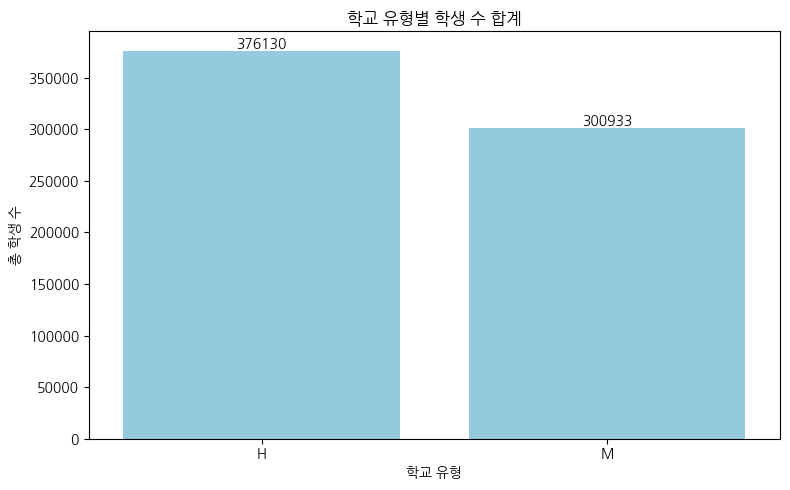

In [16]:
# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=total_student_count, x='school_type', y='student_count', color='skyblue')

# 값 표시
for i, row in total_student_count.iterrows():
    plt.text(i, row['student_count'] + 5, row['student_count'], ha='center', va='bottom')

# 라벨 설정
plt.xlabel('학교 유형')
plt.ylabel('총 학생 수')
plt.title('학교 유형별 학생 수 합계')
plt.tight_layout()
plt.show()

#### 11. accounts_timelineReport (유저 신고기록 테이블)
- reported_user_id : 신고 대상 유저 id
- user_question_record_id : 투표 기록 id

In [17]:
blob = bucket.blob('votes/accounts_timelinereport.parquet')
parquet_bytes = blob.download_as_bytes()
timelineReport = pd.read_parquet(io.BytesIO(parquet_bytes))
timelineReport.head()

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
0,28,타인을 사칭함,2023-05-06 04:44:57,874587,885082,3920588
1,37,친구를 비하하거나 조롱하는 어투,2023-05-06 05:41:19,881048,881298,4018679
2,46,친구를 비하하거나 조롱하는 어투,2023-05-06 06:26:59,887882,881945,4120914
3,64,허위 사실 언급,2023-05-06 07:07:46,888610,893684,4143049
4,65,허위 사실 언급,2023-05-06 07:07:52,888610,893684,4143049


In [18]:
timelineReport.shape

(208, 6)

In [19]:
timelineReport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       208 non-null    int64         
 1   reason                   208 non-null    object        
 2   created_at               208 non-null    datetime64[ns]
 3   reported_user_id         208 non-null    int64         
 4   user_id                  208 non-null    int64         
 5   user_question_record_id  208 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 9.9+ KB


In [20]:
timelineReport['user_id'].nunique()

115

In [21]:
timelineReport['reported_user_id'].nunique()

125

In [30]:
reason_counts = timelineReport['reason'].value_counts().reset_index()
reason_counts.columns = ['reason', 'count']
reason_counts

,reason,count
0,허위 사실 언급,80
1,친구를 비하하거나 조롱하는 어투,64
2,선정적이거나 폭력적인 내용,39
3,타인을 사칭함,15
4,광고,10


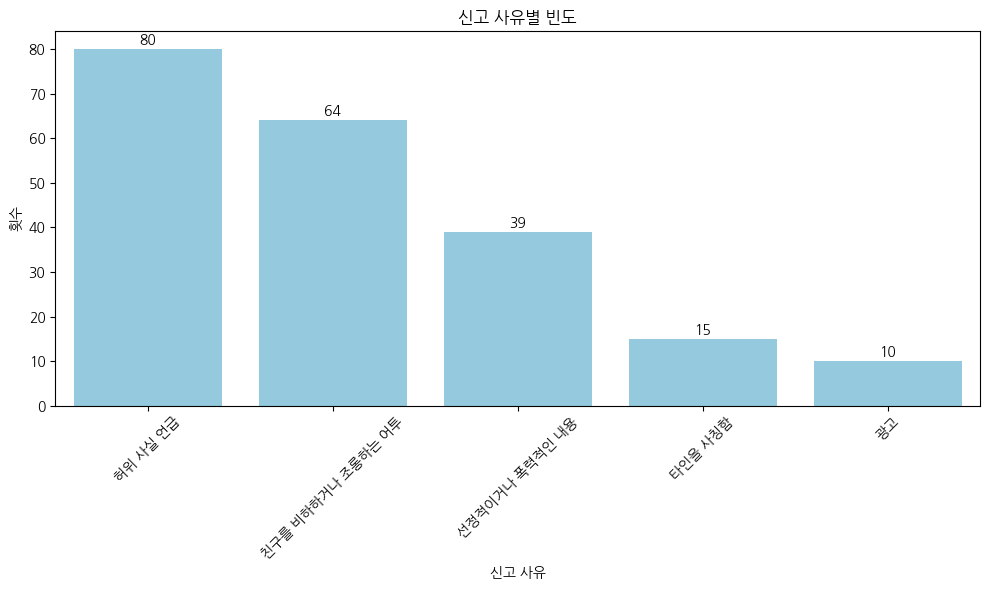

In [32]:
# reason별 신고 횟수

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=reason_counts, x='reason', y='count', color='skyblue')

# 수치 표시
for i, row in reason_counts.iterrows():
    plt.text(i, row['count'] + 0.5, row['count'], ha='center', va='bottom')

# 4. 그래프 스타일 설정
plt.xticks(rotation=45)
plt.xlabel('신고 사유')
plt.ylabel('횟수')
plt.title('신고 사유별 빈도')
plt.tight_layout()
plt.show()

In [36]:
# 신고 대상 유저 신고 기록
reported_count = timelineReport['reported_user_id'].value_counts()

# 5회 이상 신고 된 유저
frequent_reported_user = reported_count[reported_count >= 3].index
filtered_df = timelineReport[timelineReport['reported_user_id'].isin(frequent_reported_user)]
filtered_df

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
12,612,허위 사실 언급,2023-05-07 03:03:58,885473,867048,5421572
13,613,허위 사실 언급,2023-05-07 03:04:01,885473,867048,5421572
14,614,허위 사실 언급,2023-05-07 03:04:03,885473,867048,5421572
15,615,허위 사실 언급,2023-05-07 03:04:04,885473,867048,5421572
16,616,허위 사실 언급,2023-05-07 03:04:06,885473,867048,5421572
...,...,...,...,...,...,...
192,17749,허위 사실 언급,2023-05-23 15:13:54,1384178,1319092,96966251
193,17750,친구를 비하하거나 조롱하는 어투,2023-05-23 15:14:17,1384178,1319092,96966251
201,21606,허위 사실 언급,2023-05-29 11:39:09,1479859,1402487,129879776
203,21857,선정적이거나 폭력적인 내용,2023-05-29 15:42:50,1479859,1402487,131364422


In [38]:
filtered_df['reason'].value_counts().reset_index()

,reason,count
0,친구를 비하하거나 조롱하는 어투,30
1,허위 사실 언급,24
2,선정적이거나 폭력적인 내용,14
3,타인을 사칭함,8
4,광고,1


In [42]:
filtered_df['reported_user_id'].value_counts().reset_index()

,reported_user_id,count
0,1138757,15
1,1156031,8
2,939196,7
3,1187305,7
4,885129,6
5,1225963,6
6,885473,5
7,1131675,4
8,1207784,4
9,1130375,3


#### 12. accounts_user (유저 테이블)
- is_superuser : superuser 여부
- is_staff : staff 여부
- firebase_id : 과거 firebase 세션 관리 할 때 사용하는 식별자
- friend_id_list : 친구 id 데이터
- block_user_id_list : 차단한 유저 id 데이터
- hide_user_id_list : 숨김 처리한 유저 id 데이터
- ban_status : 차단 혹은 탈퇴한 유저인지 타입
- report_count : 신고 당한 횟수
- alarm_count : 알람 갯수
- pending_chat: 안읽은 채팅 개수
- pending_votes : 확인 안한 투표 개수

In [ ]:
blob = bucket.blob('votes/accounts_user.parquet')
parquet_bytes = blob.download_as_bytes()
user = pd.read_parquet(io.BytesIO(parquet_bytes))
user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [44]:
user.shape

(677085, 16)

In [45]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677085 entries, 0 to 677084
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  677085 non-null  int64         
 1   is_superuser        677085 non-null  int64         
 2   is_staff            677085 non-null  int64         
 3   gender              677083 non-null  object        
 4   point               677085 non-null  int64         
 5   friend_id_list      677085 non-null  object        
 6   is_push_on          677085 non-null  int64         
 7   created_at          677085 non-null  datetime64[ns]
 8   block_user_id_list  677085 non-null  object        
 9   hide_user_id_list   677085 non-null  object        
 10  ban_status          677085 non-null  object        
 11  report_count        677085 non-null  int64         
 12  alarm_count         677085 non-null  int64         
 13  pending_chat        677085 no

In [46]:
user['is_superuser'].value_counts()

is_superuser
0    677083
1         2
Name: count, dtype: int64

In [ ]:
def show_value_counts(df, column_names):
    """
    여러 컬럼에 대해 value_counts() 결과를 개별적으로 DataFrame으로 출력하는 함수
    """
    for col in column_names:
        if col not in df.columns:
            print(f" '{col}' 컬럼이 존재하지 않습니다.\n")
            continue

        # value_counts 결과를 DataFrame으로
        counts_df = df[col].value_counts(dropna=False).reset_index()
        counts_df.columns = [col, 'count']

        # 제목과 함께 출력
        print(f"[{col}] value_counts:")
        print(counts_df)


In [66]:
columns = ['is_superuser', 'is_staff', 'gender', 'is_push_on', 'ban_status', 'group_id']
combined_df = show_value_counts(user, columns)
display(combined_df)

[is_superuser] value_counts:
   is_superuser   count
0             0  677083
1             1       2
[is_staff] value_counts:
   is_staff   count
0         0  677082
1         1       3
[gender] value_counts:
  gender   count
0      F  396665
1      M  280418
2   None       2
[is_push_on] value_counts:
   is_push_on   count
0           1  570849
1           0  106236
[ban_status] value_counts:
  ban_status   count
0          N  668432
1          W    7855
2         NB     608
3         RB     190
[group_id] value_counts:
       group_id  count
0       67097.0     80
1        6431.0     79
2       13705.0     73
3       53560.0     69
4       36957.0     61
...         ...    ...
80908   36730.0      1
80909   36726.0      1
80910   71731.0      1
80911   61817.0      1
80912   84546.0      1

[80913 rows x 2 columns]


None

#### 13. accounts_userquestionrecord (투표 기록 테이블)

In [ ]:
blob = bucket.blob('votes/accounts_userquestionrecord.parquet')
parquet_bytes = blob.download_as_bytes()
userquestionrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
userquestionrecord.head()

#### 14. accounts_userwithdraw (탈퇴 기록 테이블)

In [ ]:
blob = bucket.blob('votes/accounts_userwithdraw.parquet')
parquet_bytes = blob.download_as_bytes()
userwithdraw = pd.read_parquet(io.BytesIO(parquet_bytes))
userwithdraw.head()

#### 15. event_receipts (포인트 이벤트 참여 테이블)

In [ ]:
blob = bucket.blob('votes/event_receipts.parquet')
parquet_bytes = blob.download_as_bytes()
receipts = pd.read_parquet(io.BytesIO(parquet_bytes))
receipts.head()

#### 16. events (포인트 이벤트 테이블)

In [ ]:
blob = bucket.blob('votes/events.parquet')
parquet_bytes = blob.download_as_bytes()
events = pd.read_parquet(io.BytesIO(parquet_bytes))
events.head()

#### 17. polls_question (질문 내용 테이블)




In [70]:
blob = bucket.blob('votes/polls_question.parquet')
parquet_bytes = blob.download_as_bytes()
polls_question = pd.read_parquet(io.BytesIO(parquet_bytes))
polls_question.head()

,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55


In [73]:
polls_question.shape

(5025, 3)

#### 18. polls_questionpiece (질문 테이블)

In [74]:
blob = bucket.blob('votes/polls_questionpiece.parquet')
parquet_bytes = blob.download_as_bytes()
questionpiece = pd.read_parquet(io.BytesIO(parquet_bytes))
questionpiece.head()

,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0


In [76]:
questionpiece.shape

(1265476, 5)

#### 19. polls_questionreport (질문에 대한 신고 기록 테이블)

In [ ]:
blob = bucket.blob('votes/polls_questionreport.parquet')
parquet_bytes = blob.download_as_bytes()
questionreport = pd.read_parquet(io.BytesIO(parquet_bytes))
questionreport.head()

#### 20. polls_questionset (질문 세트 테이블)

In [71]:
blob = bucket.blob('votes/polls_questionset.parquet')
parquet_bytes = blob.download_as_bytes()
questionset = pd.read_parquet(io.BytesIO(parquet_bytes))
questionset.head()

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477


#### 21. polls_usercandidate (질문에 등장하는 유저들 테이블)

In [72]:
blob = bucket.blob('votes/polls_usercandidate.parquet')
parquet_bytes = blob.download_as_bytes()
usercandidate = pd.read_parquet(io.BytesIO(parquet_bytes))
usercandidate.head()

,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446
